In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

In [2]:
from config import Config
cfg = Config()

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [7]:
def load_model():
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    return model, tokenizer

model, tokenizer = load_model()
WU = model.lm_head.weight

idx2t = {i:tokenizer.decode(i) for i in range(50257)}
t2idx = {tokenizer.decode(i):i for i in range(50257)}

In [8]:
#for i in range(2, 12):
#    del model.transformer.h[2]

In [9]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
def generate_sequence(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    input_ids = encoded_input["input_ids"]
    attention_mask = encoded_input.get("attention_mask", None)

    x = model.transformer(input_ids=input_ids, attention_mask=attention_mask)
    out = model.lm_head(x["last_hidden_state"])
    return input_ids, x["last_hidden_state"], out


def show_most_probable_words(out, k=5):
    values, indices = out[0, -1].topk(k)
    plt.barh(
        [idx2t[i] for i in indices.detach().cpu().numpy()][::-1],
        values.softmax(0).detach().cpu().numpy()[::-1],
    )
    plt.show()


def get_most_dissimilar_token(token):
    similarity = F.cosine_similarity(WU, WU[t2idx[token], :])
    return (-similarity).topk(5).indices[0].item()


def measure_gradients(tape):

    for name, param in model.named_parameters():
        # for name, param in model.items():
        if "attn.c_attn.weight" in name:
            W = param.grad
            # W = gradients[name]
            W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=1)

            W_Q = einops.rearrange(W_Q, "m (i h)->i m h", i=cfg.n_heads)
            W_K = einops.rearrange(W_K, "m (i h)->i m h", i=cfg.n_heads)
            W_V = einops.rearrange(W_V, "m (i h)->i m h", i=cfg.n_heads)

            for i in range(cfg.n_heads):
                name_q = (name + f"_Q.head{i}").replace("transformer.", "")
                name_k = (name + f"_K.head{i}").replace("transformer.", "")
                name_v = (name + f"_V.head{i}").replace("transformer.", "")

                if name_q not in tape.keys():
                    tape[name_q] = [W_Q[i].abs().mean().item()]
                else:
                    tape[name_q].append(W_Q[i].abs().mean().item())

                if name_k not in tape.keys():
                    tape[name_k] = [W_K[i].abs().mean().item()]
                else:
                    tape[name_k].append(W_K[i].abs().mean().item())

                if name_v not in tape.keys():
                    tape[name_v] = [W_V[i].abs().mean().item()]
                else:
                    tape[name_v].append(W_V[i].abs().mean().item())

        if "attn.c_proj.weight" in name:
            W_O = param.grad
            # W_O = gradients[name]
            W_O = einops.rearrange(W_O, "(i h) m->i h m", i=cfg.n_heads)
            for i in range(cfg.n_heads):
                name_o = (name + f"_O.head{i}").replace("transformer.", "")
                if name_o not in tape.keys():
                    tape[name_o] = [W_O[i].abs().mean().item()]
                else:
                    tape[name_o].append(W_O[i].abs().mean().item())

    return tape


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
idx_john = t2idx[' John']
idx_mary = t2idx[' Mary']
print(idx_john)
print(idx_mary)

1757
5335


In [13]:
tape_A = {}
tape_B = {}

idx_john = t2idx[' John']
idx_mary = t2idx[' Mary']

text_A = 'When Mary and John went to the store, Mary gave a drink to'
text_B = 'When Mary and John went to the store, John gave a drink to'
input_ids_A, hidden_state_A, out_A = generate_sequence(text_A)
input_ids_B, hidden_state_B, out_B = generate_sequence(text_B)

loss = F.mse_loss(out_A[:, -1, idx_john],
                  out_A[:, -1, idx_mary]) + \
       F.mse_loss(out_B[:, -1, idx_john],
                  out_B[:, -1, idx_mary])
loss.backward()

tape_A = measure_gradients(tape_A)
optimizer.zero_grad()

In [14]:
q_name = 'h.{}.attn.c_attn.weight_Q.head{}'
k_name = 'h.{}.attn.c_attn.weight_K.head{}'
v_name = 'h.{}.attn.c_attn.weight_V.head{}'
o_name = 'h.{}.attn.c_proj.weight_O.head{}'

values = []
for layer in range(12):
    head_vals = []
    for head in range(12):
        v = [
                tape_A[q_name.format(layer, head)][0],
                tape_A[k_name.format(layer, head)][0],
                tape_A[v_name.format(layer, head)][0],
                tape_A[o_name.format(layer, head)][0]
        ]

        head_vals.append(v)
    values.append(head_vals)
values = np.array(values)

0.0015823057619854808
0.0016872877022251487
0.019596679136157036
0.036185912787914276


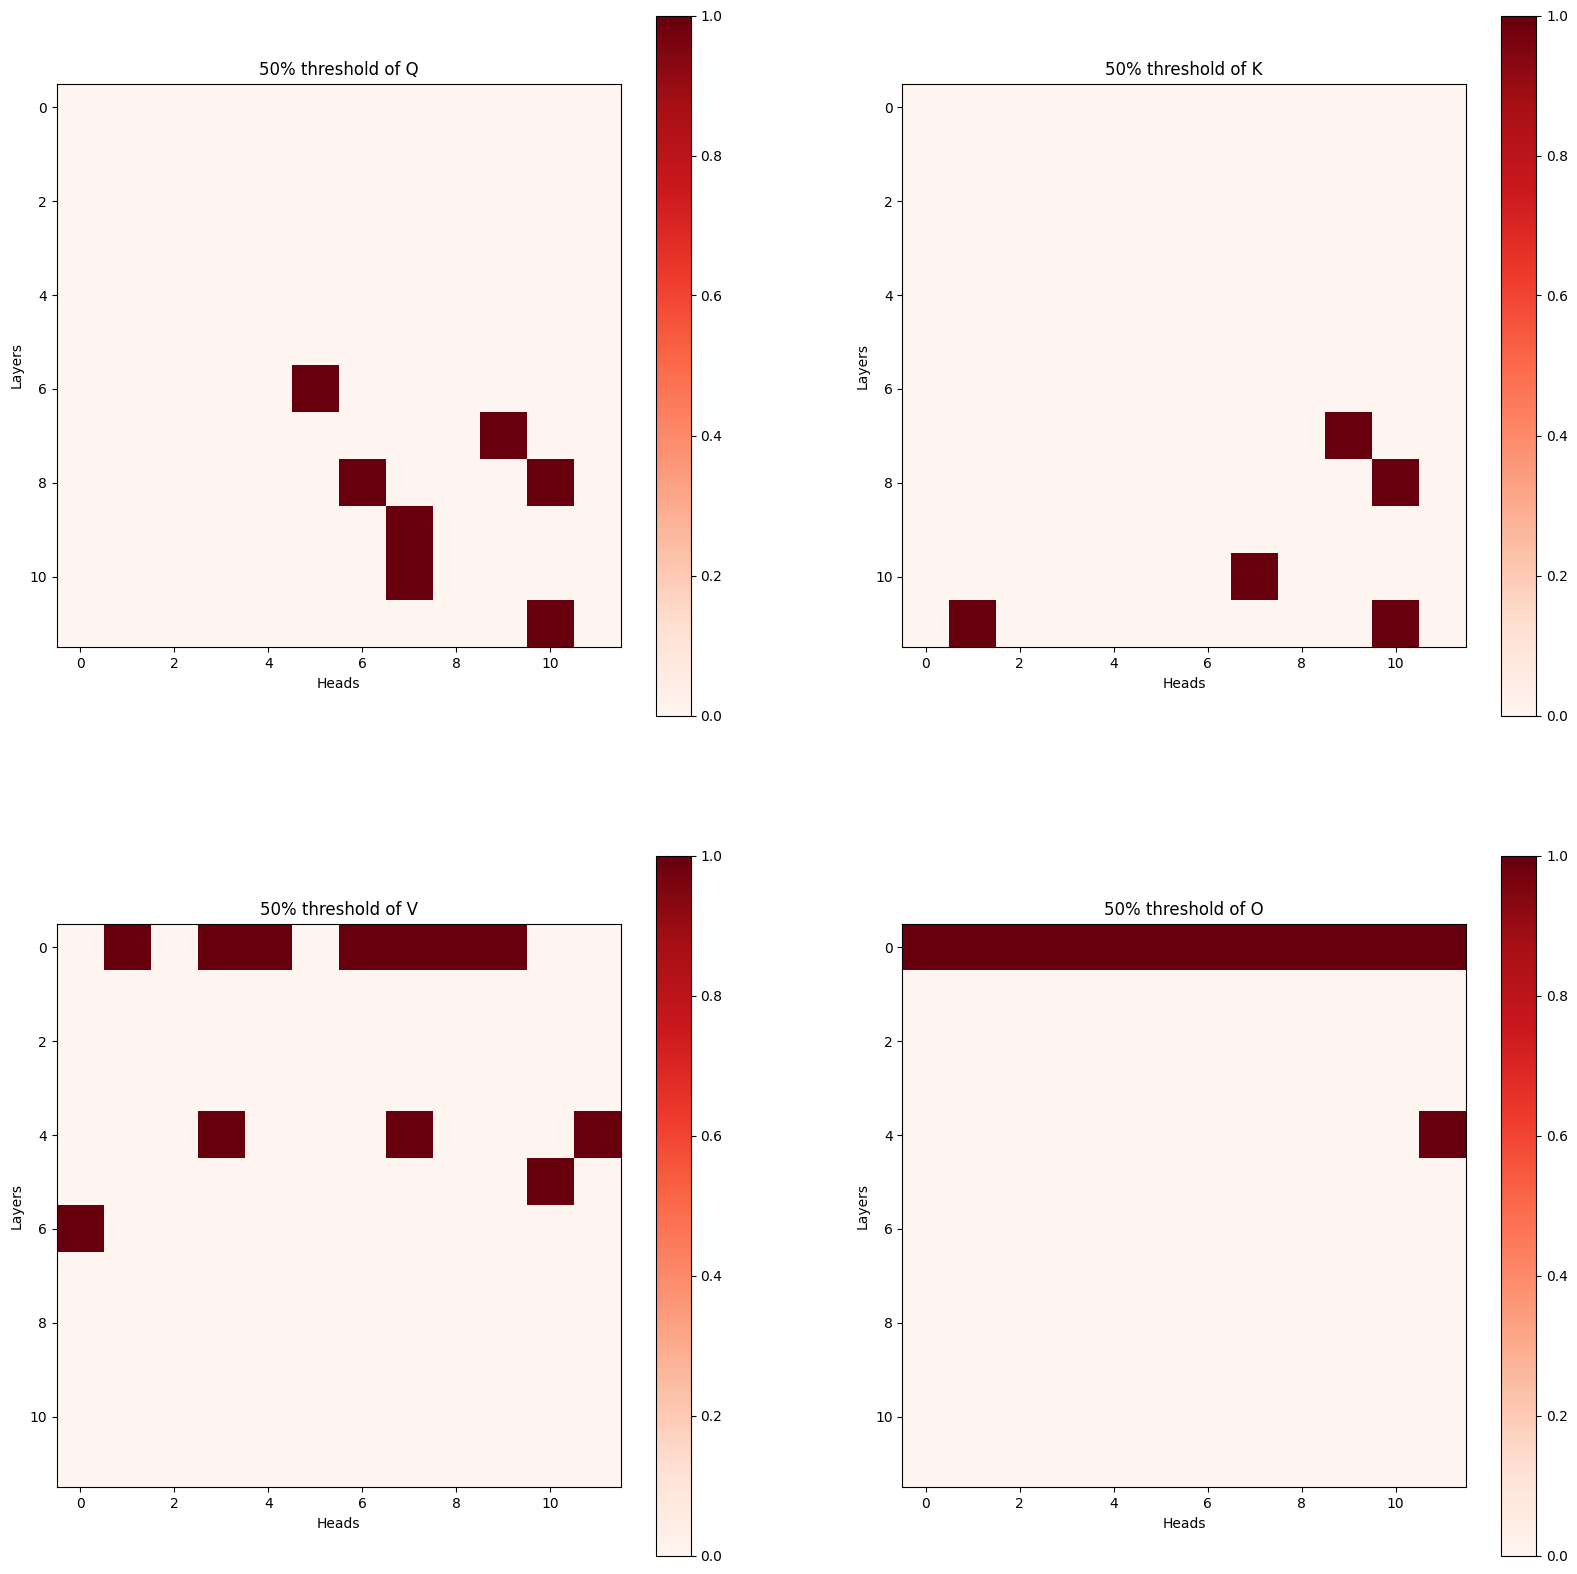

In [15]:
plt.figure(figsize=(20, 20))
for i, t in enumerate('QKVO'):
    plt.subplot(220+i+1)
    plt.xlabel('Heads')
    plt.ylabel('Layers')

    plt.title('50% threshold of '+ t)

    im = values[:, :, i]
    im_log = im
    print(im[0, 0])
    #range_ = max(im.min() - im.mean(),
    #             im.max() - im.mean())
    #norm = mpl.colors.Normalize(vmin=-range_, vmax=range_)
    plt.imshow(im > (0.5 * im.max()), cmap='Reds')
    plt.colorbar()
plt.show()

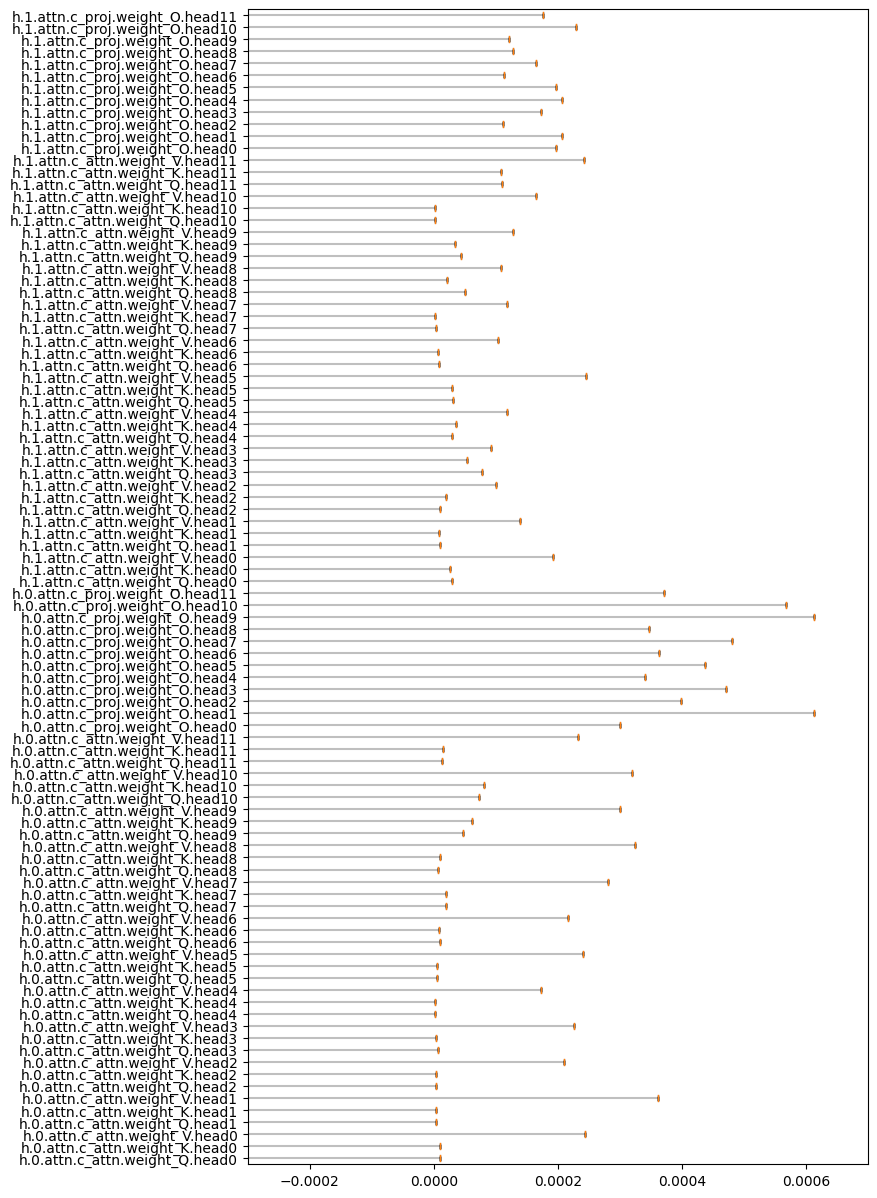

In [33]:
N = 2*(12*3 + 12)

plt.figure(figsize=(8, 15))

for i in range(N):
    plt.plot([-0.1, np.mean(list(tape.values())[i])], [i+1, i+1], c='grey', alpha=0.5)
    
plt.boxplot(list(tape.values())[:N],            
            vert=False,
            patch_artist=True)
plt.yticks(range(1, N+1),
           list(tape.keys())[:N])
plt.xlim(-0.0003, 0.0007)
plt.show()
